![](https://api.brandy.run/core/core-logo-wide)

# Mongo Geoqueries

Una de las grandes ventajas de tener una base de datos en MongoDB es la facilidade con la cual interactuar con datos geo espaciales. Para eso, utilizaremos un formato standard para esos datos, el [geoJSON](https://geojson.org)

```json
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [125.6, 10.1]
  },
  "properties": {
    "name": "Dinagat Islands"
  }
}
```

`NOTE: En las coordenadas debemos asegurarnas que esté en el siguiente orden: [longitude, latitude]`

## Preparing data

Vamos ver los datos geograficos que tenemos en nuestro dataset y tenerles en el patrón geoJSON.

In [1]:
from pymongo import MongoClient
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
url = os.getenv("url")

In [3]:
client = MongoClient(url)

In [4]:
client

MongoClient(host=['core-bdml-shard-00-02.zr1wc.mongodb.net:27017', 'core-bdml-shard-00-01.zr1wc.mongodb.net:27017', 'core-bdml-shard-00-00.zr1wc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-p4t5f9-shard-0', ssl=True)

In [5]:
db = client.get_database("core-bdml")

In [6]:
companies = db.companies

In [7]:
companies

Collection(Database(MongoClient(host=['core-bdml-shard-00-02.zr1wc.mongodb.net:27017', 'core-bdml-shard-00-01.zr1wc.mongodb.net:27017', 'core-bdml-shard-00-00.zr1wc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-p4t5f9-shard-0', ssl=True), 'core-bdml'), 'companies')

In [9]:
next(companies.find({}))

StopIteration: 

## Insert data

In [12]:
import json

In [15]:
data = []
with open("../../data/companies.json", "r") as file:
    for line in file.readlines():
        comp = json.loads(line)
        comp.pop("_id")
        data.append(comp)

In [16]:
len(data)

18801

In [18]:
data[0]

{'name': 'Wetpaint',
 'permalink': 'abc2',
 'crunchbase_url': 'http://www.crunchbase.com/company/wetpaint',
 'homepage_url': 'http://wetpaint-inc.com',
 'blog_url': 'http://digitalquarters.net/',
 'blog_feed_url': 'http://digitalquarters.net/feed/',
 'twitter_username': 'BachelrWetpaint',
 'category_code': 'web',
 'number_of_employees': 47,
 'founded_year': 2005,
 'founded_month': 10,
 'founded_day': 17,
 'deadpooled_year': 1,
 'tag_list': 'wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system',
 'alias_list': '',
 'email_address': 'info@wetpaint.com',
 'phone_number': '206.859.6300',
 'description': 'Technology Platform Company',
 'created_at': {'$date': 1180075887000},
 'updated_at': 'Sun Dec 08 07:15:44 UTC 2013',
 'overview': '<p>Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers. Wetpaint’s own online property, Wetpaint Ente

In [19]:
companies.insert_many(data)

In [20]:
next(companies.find({}))

{'_id': ObjectId('6275617c63d5059b473c119e'),
 'name': 'Wetpaint',
 'permalink': 'abc2',
 'crunchbase_url': 'http://www.crunchbase.com/company/wetpaint',
 'homepage_url': 'http://wetpaint-inc.com',
 'blog_url': 'http://digitalquarters.net/',
 'blog_feed_url': 'http://digitalquarters.net/feed/',
 'twitter_username': 'BachelrWetpaint',
 'category_code': 'web',
 'number_of_employees': 47,
 'founded_year': 2005,
 'founded_month': 10,
 'founded_day': 17,
 'deadpooled_year': 1,
 'tag_list': 'wiki, seattle, elowitz, media-industry, media-platform, social-distribution-system',
 'alias_list': '',
 'email_address': 'info@wetpaint.com',
 'phone_number': '206.859.6300',
 'description': 'Technology Platform Company',
 'created_at': {'$date': 1180075887000},
 'updated_at': 'Sun Dec 08 07:15:44 UTC 2013',
 'overview': '<p>Wetpaint is a technology platform company that uses its proprietary state-of-the-art technology and expertise in social media to build and monetize audiences for digital publishers.

In [23]:
data[0]["offices"]

[{'description': '',
  'address1': '710 - 2nd Avenue',
  'address2': 'Suite 1100',
  'zip_code': '98104',
  'city': 'Seattle',
  'state_code': 'WA',
  'country_code': 'USA',
  'latitude': 47.603122,
  'longitude': -122.333253},
 {'description': '',
  'address1': '270 Lafayette Street',
  'address2': 'Suite 505',
  'zip_code': '10012',
  'city': 'New York',
  'state_code': 'NY',
  'country_code': 'USA',
  'latitude': 40.7237306,
  'longitude': -73.9964312}]

## $unwind

Para poder crear un index geográfico e poder hacer queries geoespaciales, tenemos que no solo tener los datos en formato geoJSON, pero también que las diferentes oficinas estén en diferentes documentos. Para eso tendremos que hacer una query del tipo [aggregation](https://pymongo.readthedocs.io/en/stable/examples/aggregation.html) y usar el operador `$unwind`.

In [24]:
pipeline = [
    {"$match": {"offices.longitude": {"$ne":None}, "offices.latitude": {"$ne":None}}},
    {"$unwind": "$offices"},
    {"$project": {"_id":0}}
]

In [25]:
geo_companies = list(companies.aggregate(pipeline))

In [32]:
len(geo_companies)

9708

In [28]:
geo_companies[0]["offices"]

{'description': '',
 'address1': '710 - 2nd Avenue',
 'address2': 'Suite 1100',
 'zip_code': '98104',
 'city': 'Seattle',
 'state_code': 'WA',
 'country_code': 'USA',
 'latitude': 47.603122,
 'longitude': -122.333253}

In [29]:
geo_companies[1]["offices"]

{'description': '',
 'address1': '270 Lafayette Street',
 'address2': 'Suite 505',
 'zip_code': '10012',
 'city': 'New York',
 'state_code': 'NY',
 'country_code': 'USA',
 'latitude': 40.7237306,
 'longitude': -73.9964312}

## Create new dataset with geoJSON data

In [ ]:
q = {
    "type":"Point",
    "coordinates": ["longitude", "latitude"]
}

In [33]:
len(geo_companies)

9708

In [34]:
data = []
for gc in geo_companies:
    gc["location"] = {
        "type":"Point",
        "coordinates": [gc["offices"]["longitude"], gc["offices"]["latitude"]]
    }
    data.append(gc)

In [37]:
len(data)

9708

In [38]:
geo_companies = db.geo_companies

In [39]:
geo_companies.insert_many(data)

## Create geoIndex

Ahora que ya tenemos los datos en el formato correcto, debemos crear un nuevo index, el index geoespacial. Eso es lo que permite a mongo considerar ue cada documento pertenece a un punto sobre el globo y podremos hacer geoqueries.

Para crear el index, en la pestaña correspondiente de Mongo Compass, debemos selecionar el atributo `geometry` y definir el index como del tipo `2d sphere`.

![](img/geo_index.png)

## GeoQueries

Ahora ya está todo listo para que empecemos a realizar [Geospatial Queries](https://docs.mongodb.com/manual/geospatial-queries/), donde filtraremos los datos por su posición en el globo.

In [40]:
madrid = {
    "type":"Point",
    "coordinates": [-3.7038, 40.4168]
}

In [41]:
q = {
    "location":{
        "$near":{
            "$geometry":madrid,
            "$maxDistance": 10_000 # en metros
            # "$minDistance": 100 metros
        }
    }
}

In [42]:
res = list(geo_companies.find(q))

In [43]:
len(res)

43

In [44]:
res[0]

{'_id': ObjectId('627564cd63d5059b473c619f'),
 'name': 'Swotti',
 'permalink': 'swotti',
 'crunchbase_url': 'http://www.crunchbase.com/company/swotti',
 'homepage_url': 'http://swotti.com',
 'blog_url': '',
 'blog_feed_url': '',
 'twitter_username': '',
 'category_code': 'public_relations',
 'number_of_employees': None,
 'founded_year': None,
 'founded_month': None,
 'founded_day': None,
 'deadpooled_year': None,
 'deadpooled_month': None,
 'deadpooled_day': None,
 'deadpooled_url': None,
 'tag_list': 'semanticsearch, productreviews, opinions',
 'alias_list': '',
 'email_address': '',
 'phone_number': '',
 'description': 'semantic search engine',
 'created_at': 'Sat Mar 22 16:23:49 UTC 2008',
 'updated_at': 'Mon Dec 16 07:22:13 UTC 2013',
 'overview': '<p><a href="http://swotti.com" title="Swotti" rel="nofollow">Swotti</a> is a semantic search engine that helps consumers gather product reviews, opinions, and articles.  The site indexes over 3 million reviews, good and bad.  After searc

In [45]:
with open("../../data/spain-provinces.geojson", "r") as file:
    data = json.loads(file.read())

In [48]:
data[0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [51]:
data[0]["properties"]

{'cod_prov': '07',
 'name': 'Illes Balears',
 'cod_ccaa': '03',
 'cartodb_id': 7,
 'created_at': '2014-09-30T00:00:00Z',
 'updated_at': '2014-12-25T01:56:10Z'}

In [53]:
list_provincias = [d["properties"]["name"] for d in data]

In [74]:
list_provincias

['Illes Balears',
 'Asturias',
 'A Coruña',
 'Girona',
 'Las Palmas',
 'Pontevedra',
 'Santa Cruz De Tenerife',
 'Cantabria',
 'Málaga',
 'Almería',
 'Murcia',
 'Albacete',
 'Ávila',
 'Araba/Álava',
 'Badajoz',
 'Alacant/Alicante',
 'Ourense',
 'Barcelona',
 'Burgos',
 'Cáceres',
 'Cádiz',
 'Castelló/Castellón',
 'Ciudad Real',
 'Jaén',
 'Córdoba',
 'Cuenca',
 'Granada',
 'Guadalajara',
 'Gipuzkoa/Guipúzcoa',
 'Huelva',
 'Huesca',
 'León',
 'Lleida',
 'La Rioja',
 'Soria',
 'Navarra',
 'Ceuta',
 'Lugo',
 'Madrid',
 'Palencia',
 'Salamanca',
 'Segovia',
 'Sevilla',
 'Toledo',
 'Tarragona',
 'Teruel',
 'València/Valencia',
 'Valladolid',
 'Bizkaia/Vizcaya',
 'Zamora',
 'Zaragoza',
 'Melilla']

In [86]:
list_provincias.index("Cuenca")

25

In [87]:
coordenadas = data[25]["geometry"]["coordinates"]

In [88]:
coordenadas

[[[[-2.152111, 40.657693],
   [-2.091202, 40.646365],
   [-2.035798, 40.601566],
   [-1.985527, 40.585434],
   [-1.965905, 40.59198],
   [-1.964457, 40.611525],
   [-1.923422, 40.59188],
   [-1.909467, 40.541652],
   [-1.882003, 40.518823],
   [-1.853285, 40.423679],
   [-1.836725, 40.427657],
   [-1.811888, 40.400107],
   [-1.777769, 40.391878],
   [-1.697677, 40.321292],
   [-1.72946, 40.302908],
   [-1.719274, 40.277102],
   [-1.690346, 40.30966],
   [-1.540483, 40.190804],
   [-1.510902, 40.203715],
   [-1.474416, 40.185042],
   [-1.439208, 40.197014],
   [-1.456213, 40.130954],
   [-1.407597, 40.101404],
   [-1.420286, 40.093514],
   [-1.37686, 40.016499],
   [-1.249456, 39.995103],
   [-1.165188, 40.010096],
   [-1.142395, 39.971841],
   [-1.208184, 39.943806],
   [-1.200044, 39.858706],
   [-1.215004, 39.808774],
   [-1.275409, 39.738641],
   [-1.261995, 39.698907],
   [-1.307852, 39.670817],
   [-1.368535, 39.689615],
   [-1.417932, 39.654936],
   [-1.461796, 39.576906],
   [-1

In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
coordenadas = np.array(coordenadas)

In [91]:
coordenadas.shape

(1, 1, 126, 2)

In [93]:
x,y = coordenadas[0,0,:,0], coordenadas[0,0,:,1]

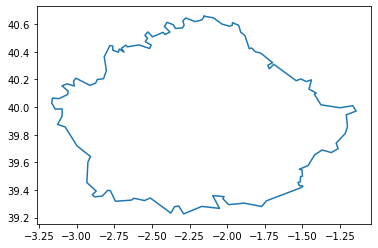

In [95]:
plt.plot(x,y)

In [101]:
res = []
for provincia in data:
    q = {
        "location":{
            "$geoWithin":{
                "$geometry":provincia["geometry"]
            }
        }
    }
    try:
        resultado = geo_companies.find(q)
        res.append((provincia["properties"]["name"], len(list(resultado))))
    except:
        res.append((provincia["properties"]["name"], "Error"))

In [102]:
res

[('Illes Balears', 0),
 ('Asturias', 3),
 ('A Coruña', 4),
 ('Girona', 1),
 ('Las Palmas', 'Error'),
 ('Pontevedra', 1),
 ('Santa Cruz De Tenerife', 0),
 ('Cantabria', 1),
 ('Málaga', 4),
 ('Almería', 0),
 ('Murcia', 1),
 ('Albacete', 0),
 ('Ávila', 0),
 ('Araba/Álava', 0),
 ('Badajoz', 0),
 ('Alacant/Alicante', 2),
 ('Ourense', 0),
 ('Barcelona', 34),
 ('Burgos', 0),
 ('Cáceres', 0),
 ('Cádiz', 0),
 ('Castelló/Castellón', 0),
 ('Ciudad Real', 0),
 ('Jaén', 0),
 ('Córdoba', 1),
 ('Cuenca', 0),
 ('Granada', 0),
 ('Guadalajara', 0),
 ('Gipuzkoa/Guipúzcoa', 1),
 ('Huelva', 0),
 ('Huesca', 0),
 ('León', 0),
 ('Lleida', 0),
 ('La Rioja', 1),
 ('Soria', 0),
 ('Navarra', 0),
 ('Ceuta', 0),
 ('Lugo', 0),
 ('Madrid', 53),
 ('Palencia', 0),
 ('Salamanca', 0),
 ('Segovia', 0),
 ('Sevilla', 2),
 ('Toledo', 1),
 ('Tarragona', 0),
 ('Teruel', 1),
 ('València/Valencia', 5),
 ('Valladolid', 0),
 ('Bizkaia/Vizcaya', 1),
 ('Zamora', 0),
 ('Zaragoza', 3),
 ('Melilla', 0)]